In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate

Using TensorFlow backend.


In [2]:
data1 = pd.read_csv('weather_data/2016_weather_data.csv', index_col = 0, parse_dates = True)

In [242]:
data1.head()

,humidity,temperature
time,,
2016-01-01 00:00:00,70.0,5.0
2016-01-01 00:05:00,70.0,5.0
2016-01-01 00:10:00,70.0,5.0
2016-01-01 00:15:00,70.0,5.0
2016-01-01 00:20:00,70.0,5.0


In [243]:
data1.describe()

,humidity,temperature
count,100122.000000,100122.000000
mean,79.379474,17.457696
std,18.697323,8.789277
min,20.000000,-7.000000
25%,67.662800,10.560000
50%,84.000000,18.330000
75%,95.000000,24.440000
max,100.000000,36.670000


In [244]:
data1.shape

(105408, 2)

In [245]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105408 entries, 2016-01-01 00:00:00 to 2016-12-31 23:55:00
Data columns (total 2 columns):
humidity       100122 non-null float64
temperature    100122 non-null float64
dtypes: float64(2)
memory usage: 2.4 MB


In [246]:
data1.isnull().sum()

humidity       5286
temperature    5286
dtype: int64

In [247]:
data1.corr()

,humidity,temperature
humidity,1.000000,0.246456
temperature,0.246456,1.000000


In [3]:
cols = ['time', 'power']

In [4]:
data2 = pd.read_csv('energy_consumption/Hotel_1_2016.csv', usecols = cols, index_col = 0, parse_dates = True)

In [5]:
data2.columns = ['power_1']

In [251]:
data2.head()

,power_1
time,
2016-01-01 00:00:00,-0.783124
2016-01-01 00:05:00,-0.817147
2016-01-01 00:10:00,-0.839047
2016-01-01 00:15:00,-0.832008
2016-01-01 00:20:00,-0.821840


In [252]:
data2.describe()

,power_1
count,1.023470e+05
mean,-2.221596e-17
std,1.000000e+00
min,-1.257098e+00
25%,-7.839066e-01
50%,-5.351880e-01
75%,9.872358e-01
max,3.100562e+00


In [253]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105408 entries, 2016-01-01 00:00:00 to 2016-12-31 23:55:00
Data columns (total 1 columns):
power_1    102347 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [254]:
data2.isna().sum()

power_1    3061
dtype: int64

In [6]:
data3 = pd.read_csv('energy_consumption/Hotel_2_2016.csv', usecols = cols, index_col = 0, parse_dates = True)

In [7]:
data3.columns = ['power_2']

In [257]:
data3.head()

,power_2
time,
2016-01-01 00:00:00,-0.854115
2016-01-01 00:05:00,-0.907222
2016-01-01 00:10:00,-0.924925
2016-01-01 00:15:00,-0.880669
2016-01-01 00:20:00,-0.983934


In [258]:
data3.describe()

,power_2
count,1.024820e+05
mean,1.020588e-16
std,1.000000e+00
min,-1.389619e+00
25%,-7.124936e-01
50%,-3.849950e-01
75%,5.030867e-01
max,4.329804e+00


In [259]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105408 entries, 2016-01-01 00:00:00 to 2016-12-31 23:55:00
Data columns (total 1 columns):
power_2    102482 non-null float64
dtypes: float64(1)
memory usage: 1.6 MB


In [260]:
data3.isna().sum()

power_2    2926
dtype: int64

In [8]:
data = pd.concat([data1, data2 ,data3], axis=1)

In [398]:
# Let's first take a look at missing values
data[pd.isna(data.humidity) & pd.isna(data.temperature)].resample('D').sum().shape

(364, 4)

In [397]:
data[pd.isna(data.power_1)].resample('D').sum().shape

(344, 4)

In [399]:
data[pd.isna(data.power_2)].resample('D').sum().shape

(359, 4)

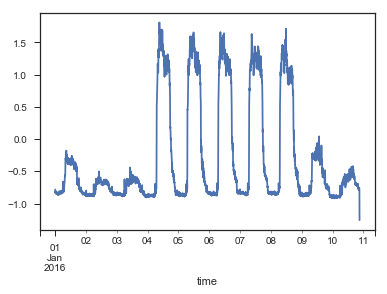

In [863]:
data['power_1'][:288*10].plot()

In [290]:
# Calculate the correlation
data.corr()

,humidity,temperature,power_1,power_2
humidity,1.000000,0.246456,-0.179753,0.105293
temperature,0.246456,1.000000,0.199918,0.663487
power_1,-0.179753,0.199918,1.000000,0.402709
power_2,0.105293,0.663487,0.402709,1.000000


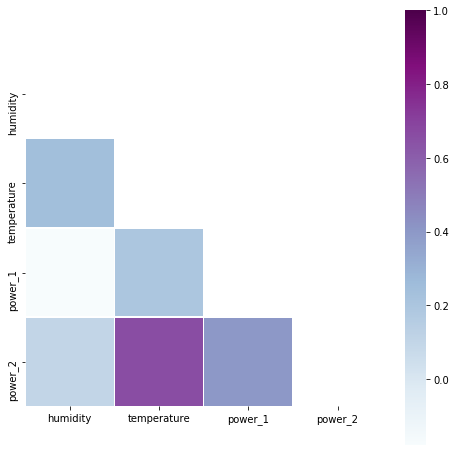

In [358]:
# Compute the correlation matrix 
corr_all = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (8, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

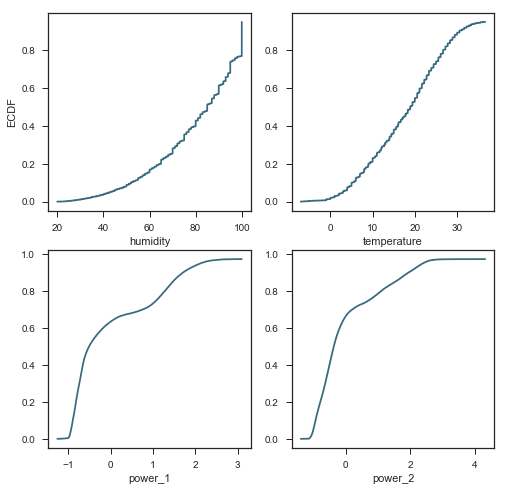

In [364]:
# Plot the ECDF
from statsmodels.distributions.empirical_distribution import ECDF

sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (8, 8))

# plot 1st ECDF
plt.subplot(221)
cdf = ECDF(data['humidity'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('humidity'); plt.ylabel('ECDF');

# plot 2nd ECDF  
plt.subplot(222)
cdf = ECDF(data['temperature'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('temperature');

# plot 3rd ECDF  
plt.subplot(223)
cdf = ECDF(data['power_1'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('power_1');

# plot 4th ECDF  
plt.subplot(224)
cdf = ECDF(data['power_2'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('power_2');

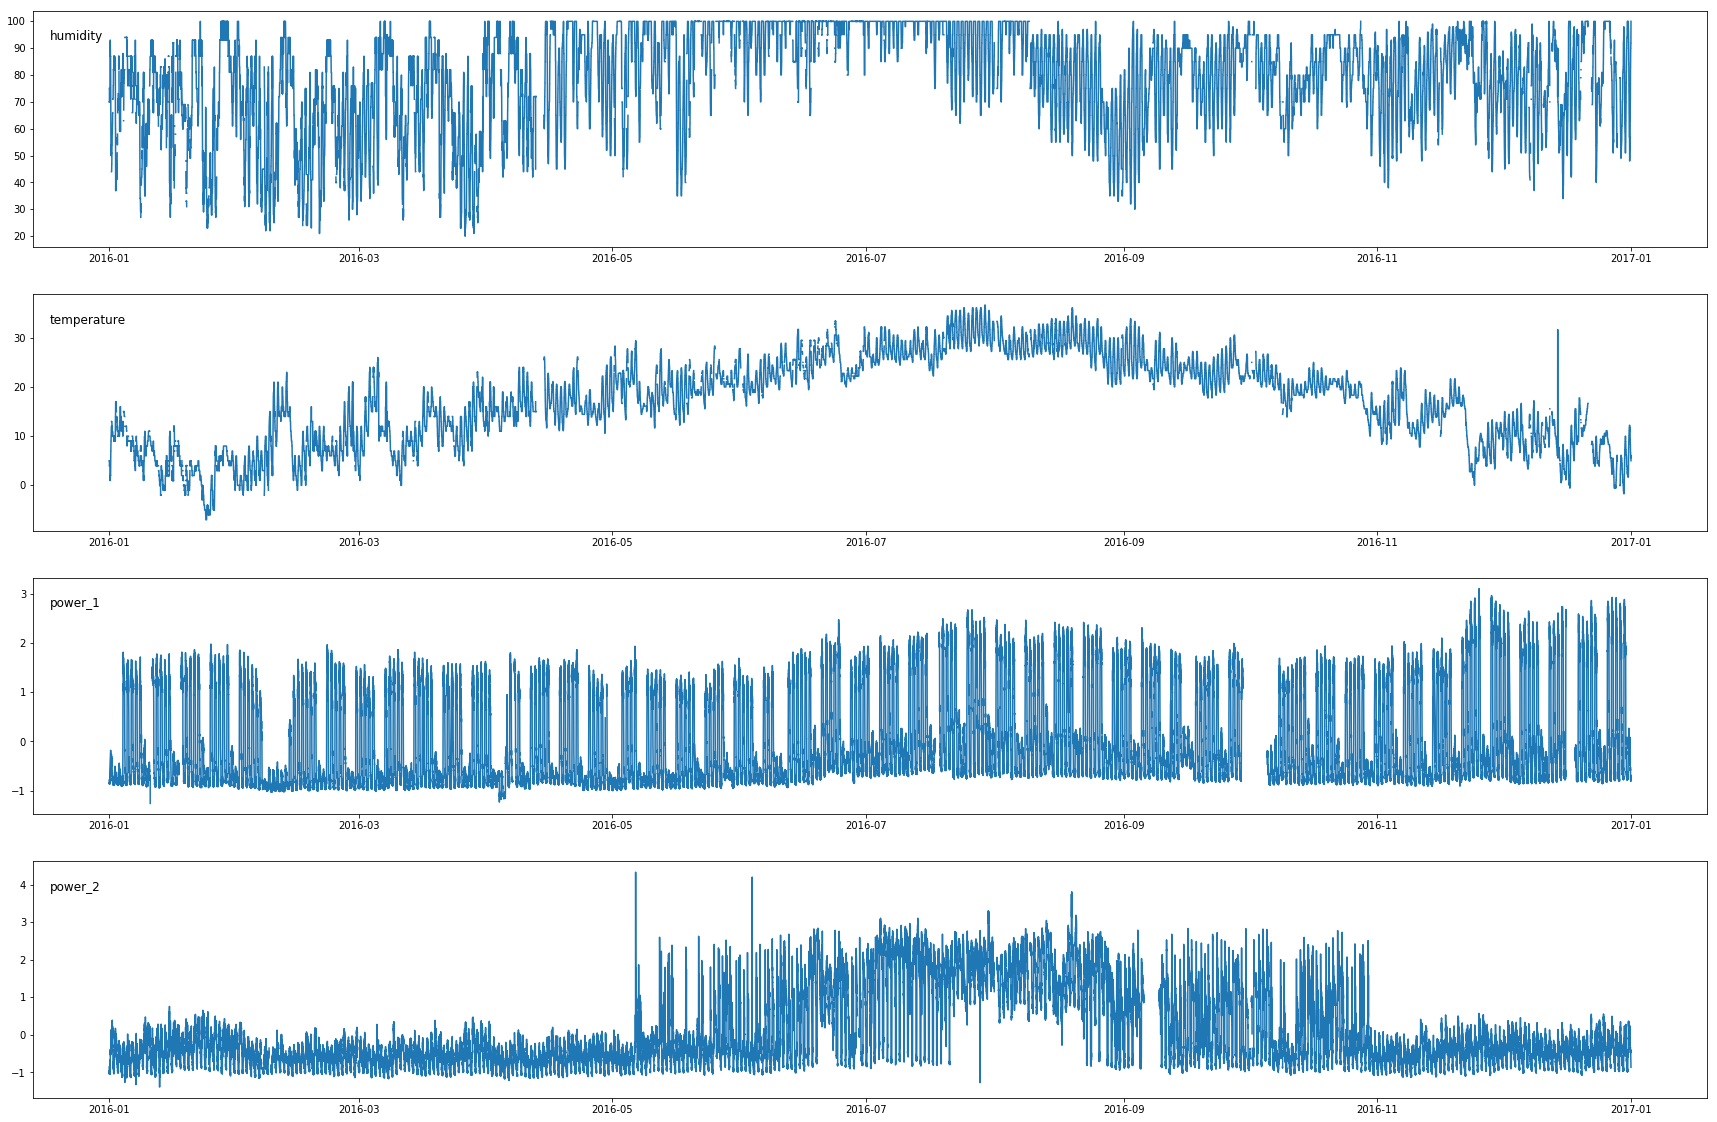

In [324]:
# plot each column
i = 1
cols_to_plot = ['humidity', 'temperature', 'power_1', 'power_2']
plt.figure(figsize = (30, 20))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(data[col])
    plt.title(col, x = 0.01, y = 0.85, loc = 'left')
    i += 1
plt.show()

In [9]:
# Extract timestamp components as new features
data['Minute'] = data.index.minute
data['Hour'] = data.index.hour
data['DayofWeek'] = data.index.dayofweek
data['Day'] = data.index.day
data['WeekofYear'] = data.index.weekofyear
data['Month'] = data.index.month

In [10]:
data.head()

,humidity,temperature,power_1,power_2,Minute,Hour,DayofWeek,Day,WeekofYear,Month
time,,,,,,,,,,
2016-01-01 00:00:00,70.0,5.0,-0.783124,-0.854115,0,0,4,1,53,1
2016-01-01 00:05:00,70.0,5.0,-0.817147,-0.907222,5,0,4,1,53,1
2016-01-01 00:10:00,70.0,5.0,-0.839047,-0.924925,10,0,4,1,53,1
2016-01-01 00:15:00,70.0,5.0,-0.832008,-0.880669,15,0,4,1,53,1
2016-01-01 00:20:00,70.0,5.0,-0.821840,-0.983934,20,0,4,1,53,1


In [864]:
data.describe()

,humidity,temperature,power_1,power_2,Hour,DayofWeek,Day,WeekofYear,Month,Minute
count,100122.000000,100122.000000,1.023470e+05,1.024820e+05,105408.000000,105408.000000,105408.000000,105408.000000,105408.000000,105408.000000
mean,79.379474,17.457696,-2.221596e-17,1.020588e-16,11.500000,3.008197,15.756831,26.647541,6.513661,27.500000
std,18.697323,8.789277,1.000000e+00,1.000000e+00,6.922219,1.997942,8.811571,15.098974,3.451250,17.260345
min,20.000000,-7.000000,-1.257098e+00,-1.389619e+00,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,67.662800,10.560000,-7.839066e-01,-7.124936e-01,5.750000,1.000000,8.000000,14.000000,4.000000,13.750000
50%,84.000000,18.330000,-5.351880e-01,-3.849950e-01,11.500000,3.000000,16.000000,27.000000,7.000000,27.500000
75%,95.000000,24.440000,9.872358e-01,5.030867e-01,17.250000,5.000000,23.000000,40.000000,10.000000,41.250000
max,100.000000,36.670000,3.100562e+00,4.329804e+00,23.000000,6.000000,31.000000,53.000000,12.000000,55.000000


In [150]:
# RNN Approach
# Define function for data transformation
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Output sequence
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
data_full = data.dropna()

df_train = data_full.iloc[:(-31*288), :].copy()
df_test = data_full.iloc[-31*288:, :].copy()

## take out the useful columns for modeling
X_cols = ['humidity', 'temperature', 'Hour', 'DayofWeek', 'Day', 'WeekofYear', 'Month', 'Minute']
y_cols = ['power_1']

X_train = df_train[X_cols].values.copy()
X_test = df_test[X_cols].values.copy()
y_train = df_train[y_cols].values.copy().reshape(-1, 1)
y_test = df_test[y_cols].values.copy().reshape(-1, 1)

In [553]:
#X = X.astype(np.float32)
#y = y.values.ravel()

# split the data into train/test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [12]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0,1))

# Transfrom both train and test sets
df_train_scaled = scaler.fit_transform(df_train)
df_test_scaled = scaler.transform(df_test)

## take out the useful columns for modeling
X_cols_int = [0,1,4,5,6,7,8,9]
y_cols_int = [2]

X_train_scaled = pd.DataFrame(df_train_scaled)[X_cols_int].values.copy()
X_test_scaled = pd.DataFrame(df_test_scaled)[X_cols_int].values.copy()
y_train_scaled = pd.DataFrame(df_train_scaled)[y_cols_int].values.copy().reshape(-1, 1)
y_test_scaled = pd.DataFrame(df_test_scaled)[y_cols_int].values.copy().reshape(-1, 1)

# Convert it to supervised learning format
# reframed = series_to_supervised(scaled, 1, 1)

In [14]:
#Split it into train and test
#split = math.floor(scaled.shape[0]*0.7)
#train = scaled[:split, :]
#test = scaled[split:, :]

# Split it into input and output
#train_x, train_y = train[:, :-1], train[:, -1]
#test_x, test_y = test[:, :-1], test[:, -1]

# Reshape the input to be 3D
X_train_reshaped= X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [951]:
X_train_reshaped.shape

(86411, 1, 8)

In [950]:
y_train_scaled.reshape(-1,).shape

(86411,)

In [952]:
X_test_reshaped.shape

(8928, 1, 8)

In [953]:
y_test_scaled.reshape(-1,).shape

(8928,)

In [956]:
tf.reset_default_graph()

In [15]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# Fit network
history = model.fit(X_train_reshaped, y_train_scaled.reshape(-1,), epochs=200, batch_size=64, validation_data=(X_test_reshaped, y_test_scaled.reshape(-1,)), verbose =2, shuffle=False)

Train on 86411 samples, validate on 8928 samples
Epoch 1/200
 - 4s - loss: 0.1555 - val_loss: 0.2111
Epoch 2/200
 - 3s - loss: 0.1495 - val_loss: 0.2116
Epoch 3/200
 - 3s - loss: 0.1439 - val_loss: 0.2084
Epoch 4/200
 - 3s - loss: 0.1346 - val_loss: 0.1995
Epoch 5/200
 - 3s - loss: 0.1265 - val_loss: 0.1874
Epoch 6/200
 - 3s - loss: 0.1225 - val_loss: 0.1805
Epoch 7/200
 - 3s - loss: 0.1203 - val_loss: 0.1742
Epoch 8/200
 - 3s - loss: 0.1184 - val_loss: 0.1704
Epoch 9/200
 - 3s - loss: 0.1162 - val_loss: 0.1656
Epoch 10/200
 - 3s - loss: 0.1135 - val_loss: 0.1601
Epoch 11/200
 - 3s - loss: 0.1105 - val_loss: 0.1555
Epoch 12/200
 - 3s - loss: 0.1076 - val_loss: 0.1486
Epoch 13/200
 - 3s - loss: 0.1050 - val_loss: 0.1416
Epoch 14/200
 - 3s - loss: 0.1026 - val_loss: 0.1355
Epoch 15/200
 - 3s - loss: 0.1005 - val_loss: 0.1315
Epoch 16/200
 - 3s - loss: 0.0985 - val_loss: 0.1281
Epoch 17/200
 - 3s - loss: 0.0968 - val_loss: 0.1251
Epoch 18/200
 - 3s - loss: 0.0954 - val_loss: 0.1225
Epoch 

Epoch 154/200
 - 3s - loss: 0.0472 - val_loss: 0.0652
Epoch 155/200
 - 3s - loss: 0.0479 - val_loss: 0.0651
Epoch 156/200
 - 3s - loss: 0.0472 - val_loss: 0.0648
Epoch 157/200
 - 3s - loss: 0.0474 - val_loss: 0.0644
Epoch 158/200
 - 3s - loss: 0.0472 - val_loss: 0.0647
Epoch 159/200
 - 3s - loss: 0.0472 - val_loss: 0.0670
Epoch 160/200
 - 3s - loss: 0.0472 - val_loss: 0.0680
Epoch 161/200
 - 3s - loss: 0.0471 - val_loss: 0.0643
Epoch 162/200
 - 3s - loss: 0.0476 - val_loss: 0.0658
Epoch 163/200
 - 3s - loss: 0.0468 - val_loss: 0.0644
Epoch 164/200
 - 3s - loss: 0.0472 - val_loss: 0.0667
Epoch 165/200
 - 3s - loss: 0.0469 - val_loss: 0.0660
Epoch 166/200
 - 3s - loss: 0.0468 - val_loss: 0.0646
Epoch 167/200
 - 3s - loss: 0.0471 - val_loss: 0.0661
Epoch 168/200
 - 3s - loss: 0.0468 - val_loss: 0.0642
Epoch 169/200
 - 3s - loss: 0.0471 - val_loss: 0.0638
Epoch 170/200
 - 3s - loss: 0.0464 - val_loss: 0.0632
Epoch 171/200
 - 3s - loss: 0.0465 - val_loss: 0.0636
Epoch 172/200
 - 3s - loss: 

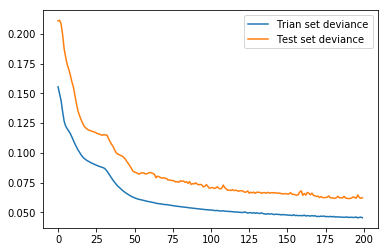

In [16]:
# Plot
plt.plot(history.history['loss'], label='Trian set deviance')
plt.plot(history.history['val_loss'], label='Test set deviance')
plt.legend()
plt.show()

In [18]:
# Make prediciton
yhat = model.predict(X_test_reshaped)

In [545]:
# Invert scaling for forecast
#X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[2])
#inv_yhat = concatenate((yhat, X_test_scaled), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
#y_test = y_test.reshape(y_test.shape[0], 1)
#inv_y = concatenate((y_test, X_test_scaled), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

In [30]:
# Calculate Metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mse = mean_squared_error(y_test_scaled, yhat)
print("MSE: %.5f" % mse)
mae = mean_absolute_error(y_test_scaled, yhat)
print('MAE: %.5f' % mae)
mape = mean_absolute_percentage_error(y_test_scaled, yhat)
print('MAPE: %.5f' % mape)

MSE: 0.00715
MAE: 0.06222
MAPE: 25.22068


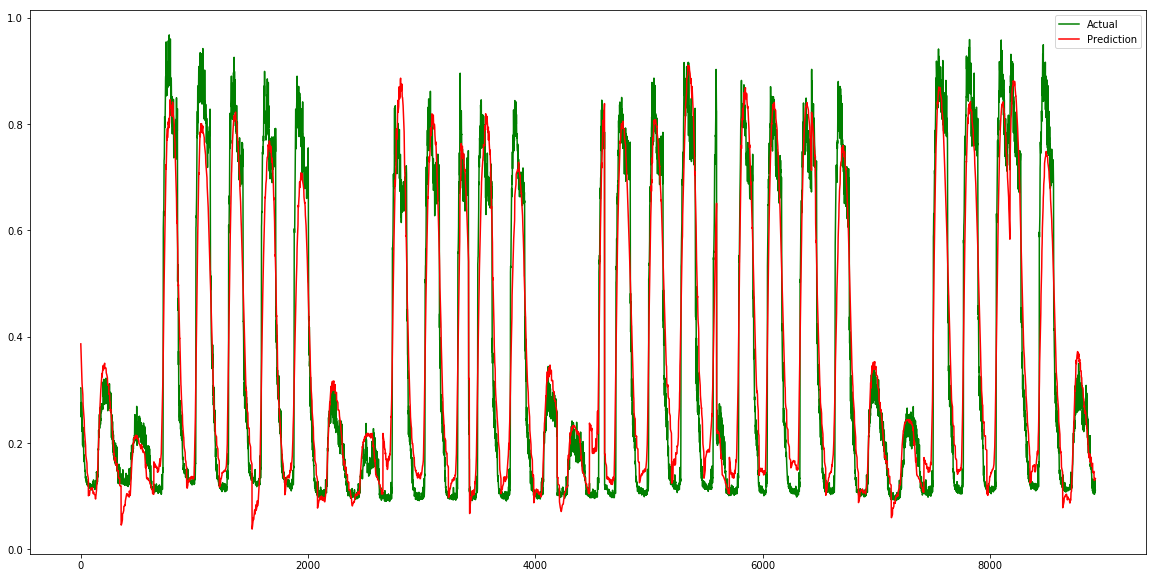

In [31]:
plt.figure(figsize = (20, 10))
plt.plot(y_test_scaled, color ='g', label = 'Actual')
plt.plot(yhat, color = 'r', label = 'Prediction')
plt.legend()

In [219]:
result1.to_csv('test1.csv')

In [21]:
# GB Rregressor Approach
#X_cols = ['humidity', 'temperature', 'Hour', 'DayofWeek', 'Day', 'WeekofYear', 'Month']
#y_cols = ['power_1']
#data_full = data.dropna()
#X, y = data_full[X_cols], data_full[y_cols]
#X = X.astype(np.float32)
#y = y.values.ravel()

# split the data into train/test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [24]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train.reshape(-1,))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [25]:
# Calculate Metrics
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.5f" % mse)
mae = mean_absolute_error(y_test, clf.predict(X_test))
print("MAE: %.5f" % mae)
mape = mean_absolute_percentage_error(y_test, clf.predict(X_test))
print('MAPE: %.5f' % mape)

MSE: 0.18406
MAE: 0.32319
MAPE: 429.92440


Text(0,0.5,'Deviance')

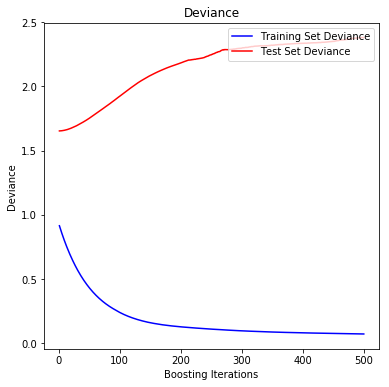

In [26]:
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

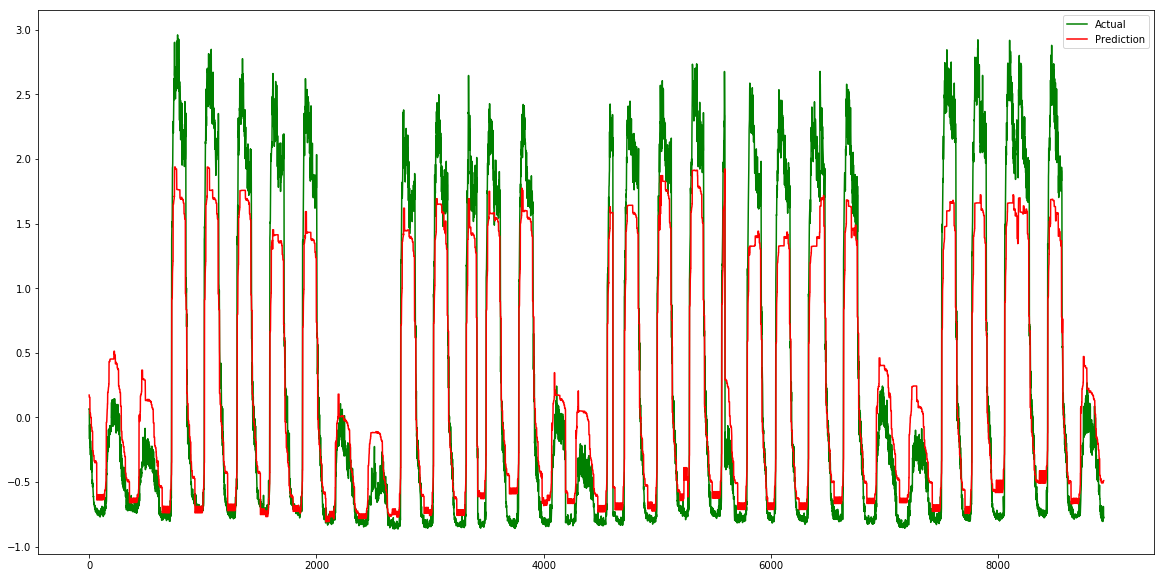

In [27]:
plt.figure(figsize = (20, 10))
plt.plot(y_test, color ='g', label = 'Actual')
plt.plot(clf.predict(X_test), color = 'r', label = 'Prediction')
plt.legend()

In [625]:
# ARIMA approach
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

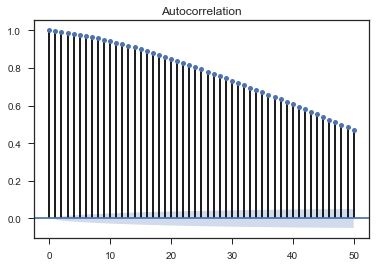

In [654]:
_ = plot_acf(data_full['power_1'], lags = 50)

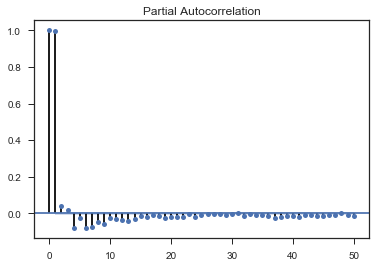

In [655]:
_ = plot_pacf(data_full['power_1'], lags = 50)

                             ARIMA Model Results                              
Dep. Variable:              D.power_1   No. Observations:                95338
Model:                 ARIMA(5, 1, 1)   Log Likelihood               88089.899
Method:                       css-mle   S.D. of innovations              0.096
Date:                Wed, 03 Jan 2018   AIC                        -176163.797
Time:                        15:24:07   BIC                        -176088.076
Sample:                    01-01-2016   HQIC                       -176140.768
                         - 12-31-2016                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.546e-07      0.001     -0.001      0.999      -0.001       0.001
ar.L1.D.power_1     0.7913      0.007    107.893      0.000       0.777       0.806
ar.L2.D.power_1     0.0120      

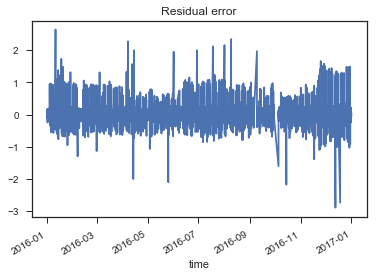

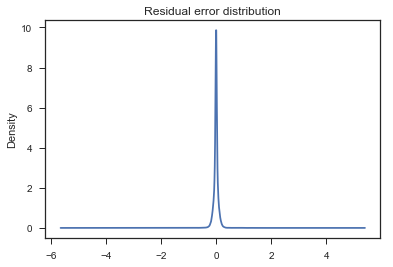

In [665]:
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(data_full['power_1'], order=(5,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(legend = False)
plt.title('Residual error')
residuals.plot(kind='kde', legend = False)
plt.title('Residual error distribution')
print(residuals.describe())

In [351]:
# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

/Users/allen/python3-env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [352]:
from fbprophet import Prophet

In [928]:
# Seq2Seq Approach (RNN)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 
input_seq_len = 288
output_seq_len = 144
 
def generate_train_samples(x = X_train_scaled, y = y_train_scaled, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
 
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
 
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
 
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
 
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)
 
def generate_test_samples(x = X_test_scaled, y = y_test_scaled, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
 
    total_samples = x.shape[0]
 
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
 
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
 
    return input_seq, output_seq

In [929]:
x, y = generate_train_samples()
print(x.shape, y.shape)

(10, 288, 8) (10, 144, 1)


In [930]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

(8496, 288, 8) (8496, 144, 1)


In [931]:
# Build the model
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import copy
 
## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003 
 
## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64
# num of input signals
input_dim = X_train_scaled.shape[1]
# num of output signals
output_dim = y_train_scaled.shape[1]
# num of stacked lstm layers
num_stacked_layers = 2
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5
 
def build_graph(feed_previous = False):
 
    tf.reset_default_graph()
 
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
 
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
 
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]
 
        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]
 
        # Give a "GO" token to the decoder.
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]
 
        with tf.variable_scope('LSTMCell'):
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
 
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state
 
        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous
              decoder output using _loop_function below. If False, decoder_inputs are used
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)
 
        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
 
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp,
            dec_inp,
            cell,
            feed_previous = feed_previous
        )
 
        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
 
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))
 
        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
 
        loss = output_loss + lambda_l2_reg * reg_loss
 
    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
 
    saver = tf.train.Saver
 
    return dict(
        enc_inp = enc_inp,
        target_seq = target_seq,
        train_op = optimizer,
        loss=loss,
        saver = saver,
        reshaped_outputs = reshaped_outputs,
        )

In [932]:
# Train the model
import os

total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []
 
rnn_model = build_graph(feed_previous=False)
 
saver = tf.train.Saver()
 
init = tf.global_variables_initializer()
with tf.Session() as sess:
 
    sess.run(init)
 
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
 
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
 
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('/Users/allen/Documents/projects/personal/competition/datadreams/', 'multivariate_ts_model0'))
 
print("Checkpoint saved at: ", save_path)

Training losses: 
12.1508
2402.22
27.8841
116.674
26.8398
8.00244
4.23123
3.03206
2.66545
1.36212
2.7081
1.81663
2.49174
3.56381
1.21144
1.63153
2.09379
1.06086
1.01889
1.35718
0.376589
0.835217
1.60933
1.03332
0.344788
0.413953
0.288305
0.900493
1.20008
0.713354
0.227328
0.268436
0.261998
0.335398
0.179429
0.462537
0.479707
0.256817
0.513957
0.600649
0.358451
0.477522
0.332342
0.215273
0.246275
0.373926
0.540491
0.669016
0.610146
0.433795
0.321815
0.634761
1.30517
1.26498
0.667235
0.286862
0.508956
0.890225
1.00374
1.42803
0.465162
0.260311
0.45317
0.545554
0.505081
0.313511
0.53018
0.781804
0.449664
0.454981
0.372171
0.23476
0.296117
0.43479
0.348622
0.289456
0.453508
0.387161
0.189357
0.240841
0.178033
0.19975
0.1814
0.243273
0.179043
0.153625
0.152237
0.184369
0.201996
0.140163
0.196171
0.155646
0.203745
0.24013
0.347852
0.232444
0.298423
0.507944
0.467367
0.193219
Checkpoint saved at:  /Users/allen/Documents/projects/personal/competition/datadreams/multivariate_ts_model0


In [933]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('/Users/allen/Documents/projects/personal/competition/datadreams/', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from /Users/allen/Documents/projects/personal/competition/datadreams/multivariate_ts_model0


INFO:tensorflow:Restoring parameters from /Users/allen/Documents/projects/personal/competition/datadreams/multivariate_ts_model0


Test mse is:  0.525068480793


In [934]:
# remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], output_seq_len)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], output_seq_len)], axis = 0)

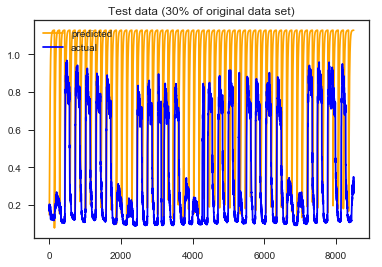

In [936]:
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("Test data (30% of original data set)")
plt.legend(loc="upper left")
plt.show()